# Undertake sensitivity analysis and optimisation

### import packages

In [18]:
%%time

import sys
import os
import numpy as np
import pandas as pd
import scipy as sci
from scipy.stats import gaussian_kde, skew, pearsonr
from scipy.special import expit, logit
import random

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import seaborn as sns

import SALib as SAL
from SALib.sample import saltelli
from SALib.analyze import sobol

import sklearn as skl
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern,WhiteKernel,ConstantKernel,RBF
from sklearn.gaussian_process.kernels import DotProduct,ExpSineSquared,RationalQuadratic
from sklearn.utils import resample
from sklearn.metrics import r2_score

import joblib
from joblib import Parallel, delayed
from multiprocessing import Pool

import emcee


# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("sklearn version =", skl.__version__)
print("SALib version =", SAL.__version__)
print("seaborn version =", sns.__version__)
print("emcee version =", emcee.__version__)


wrkdir="/home/581/pjb581/gtracer_optimisation"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.3
scipy version = 1.14.1
matplotlib version = 3.9.2
cmocean version = v3.0.3
sklearn version = 1.5.2
SALib version = 1.4.7
seaborn version = 0.13.2
emcee version = 3.1.6
CPU times: user 411 μs, sys: 0 ns, total: 411 μs
Wall time: 379 μs


'/home/581/pjb581/gtracer_optimisation'

## Sensitivity analysis

### read in the normalised parameter sets that were used as input for the forward model runs

In [2]:
%%time
X = pd.read_excel('normalised_parameter_sets_512.xlsx', header=0, usecols=lambda column: column != 'Unnamed: 0')
X

CPU times: user 348 ms, sys: 182 ms, total: 530 ms
Wall time: 7.07 s


,abioa,phykf,phylmor,zooepsmin,zooepsmax,zoolmor,zooqmor,zooassi,abioh,detlrem,wdetbio,knano_dfe,kscav_dfe,kcoag_dfe
0,0.987100,0.802393,0.011476,0.175775,0.829965,0.020376,0.028623,0.305757,0.718250,0.069816,0.549095,0.872515,0.703173,0.103371
1,0.136770,0.439292,0.609545,0.774254,0.394633,0.911775,0.537901,0.634635,0.372011,0.717913,0.372649,0.055286,0.304884,0.742743
2,0.453992,0.725447,0.402298,0.355883,0.207555,0.558296,0.493075,0.924541,0.056318,0.968087,0.109087,0.497300,0.981465,0.475979
3,0.670059,0.018219,0.968844,0.694608,0.517035,0.385525,0.940829,0.002437,0.900536,0.319379,0.781636,0.680498,0.005105,0.865405
4,0.596304,0.528645,0.720347,0.550343,0.626732,0.215800,0.262278,0.797994,0.231303,0.612791,0.199380,0.503879,0.846893,0.564018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.594604,0.229937,0.943683,0.002363,0.937433,0.555184,0.930859,0.741478,0.077875,0.650369,0.379787,0.194448,0.813895,0.419910
508,0.668360,0.723176,0.695246,0.240850,0.796241,0.858153,0.366002,0.441522,0.805920,0.419488,0.602209,0.121284,0.038512,0.150747
509,0.455696,0.016586,0.183603,0.841350,0.479131,0.218546,0.825475,0.614119,0.151182,0.802578,0.288545,0.806494,0.952456,0.510827
510,0.138976,0.804648,0.835796,0.290236,0.166209,0.314274,0.143977,0.827871,0.468340,0.552374,0.052105,0.746557,0.275780,0.270388


### read in the performance metrics of each experiment (RMSE and correlation)

In [3]:
### RMSE
gl = pd.read_excel("8targets_RMSE.xlsx", header=0)
so = pd.read_excel("8targets_so_RMSE.xlsx", header=0)
eq = pd.read_excel("8targets_eq_RMSE.xlsx", header=0)

rmse = pd.concat([eq['surno3_rmse'], gl['surfer_rmse'], gl['surchl_rmse'], gl['chmaxz_rmse'], \
                  gl['intnpp_rmse'], so['fgco2_rmse'], gl['phylim_rmse'], gl['pocsink_rmse']], axis=1)

### STD
gl = pd.read_excel("8targets_SDEV.xlsx", header=0)
so = pd.read_excel("8targets_so_SDEV.xlsx", header=0)
eq = pd.read_excel("8targets_eq_SDEV.xlsx", header=0)

sdev = pd.concat([eq['surno3_sdev'], gl['surfer_sdev'], gl['surchl_sdev'], gl['chmaxz_sdev'], \
                  gl['intnpp_sdev'], so['fgco2_sdev'], gl['phylim_sdev'], gl['pocsink_sdev']], axis=1)

### correlations
gl = pd.read_excel("8targets_CCOEF.xlsx", header=0)
so = pd.read_excel("8targets_so_CCOEF.xlsx", header=0)
eq = pd.read_excel("8targets_eq_CCOEF.xlsx", header=0)

corr = pd.concat([eq['surno3_ccoef'], gl['surfer_ccoef'], gl['surchl_ccoef'], gl['chmaxz_ccoef'], \
                  gl['intnpp_ccoef'], so['fgco2_ccoef'], gl['phylim_ccoef'], gl['pocsink_ccoef']], axis=1)

rmse.columns = rmse.columns.str[:6]
sdev.columns = sdev.columns.str[:6]
corr.columns = corr.columns.str[:6]

print(corr.min(axis=0), corr.max(axis=0))

surno3    0.432646
surfer   -0.225706
surchl   -0.351727
chmaxz   -0.188274
intnpp    0.087862
fgco2_   -0.029242
phylim    0.104683
pocsin   -0.079931
dtype: float64 surno3    0.713707
surfer    0.571161
surchl    0.809181
chmaxz    0.773871
intnpp    0.410729
fgco2_    0.496742
phylim    0.846233
pocsin    0.601266
dtype: float64


### create the cost function

In [4]:
### NSTD
gl = pd.read_excel("8targets_NSDEV.xlsx", header=0)
so = pd.read_excel("8targets_so_NSDEV.xlsx", header=0)
eq = pd.read_excel("8targets_eq_NSDEV.xlsx", header=0)

nsdev = pd.concat([eq['surno3_nsdev'], gl['surfer_nsdev'], gl['surchl_nsdev'], gl['chmaxz_nsdev'], \
                  gl['intnpp_nsdev'], so['fgco2_nsdev'], gl['phylim_nsdev'], gl['pocsink_nsdev']], axis=1)

nsdev.columns = nsdev.columns.str[:6]

### solve for the observational standard deviation using the normalised standard deviation
obs_std = sdev / nsdev

### calculate the cost function, penalizing experiments where the correlations are very poor
nrmse = (rmse/obs_std)
cost = (1 - corr) * nrmse
cost

,surno3,surfer,surchl,chmaxz,intnpp,fgco2_,phylim,pocsin
0,0.539777,1.017189,0.293658,0.468051,0.798643,0.891319,0.110296,0.509791
1,0.615633,1.272938,0.894960,0.759498,1.072670,1.651951,0.982671,0.546157
2,0.604930,1.273738,1.330434,0.754902,0.727609,1.594992,0.695272,0.565063
3,0.727423,1.167772,0.219772,3.395486,1.142774,1.052668,0.621980,0.485149
4,0.551942,1.100829,0.778415,0.718805,0.726343,1.491127,0.538583,0.522446
...,...,...,...,...,...,...,...,...
507,0.464066,1.395865,0.560235,0.729958,0.751707,1.295885,0.326493,0.498380
508,0.566392,0.994737,0.477238,0.771218,0.700524,1.162100,0.389262,0.390402
509,0.460933,1.886146,0.665000,0.596584,0.938598,1.046818,0.519450,0.453062
510,0.714664,1.822191,0.874571,1.299607,1.062728,1.741891,0.537353,0.696034


### check out the distributions of the RMSE, the correlation and the cost function

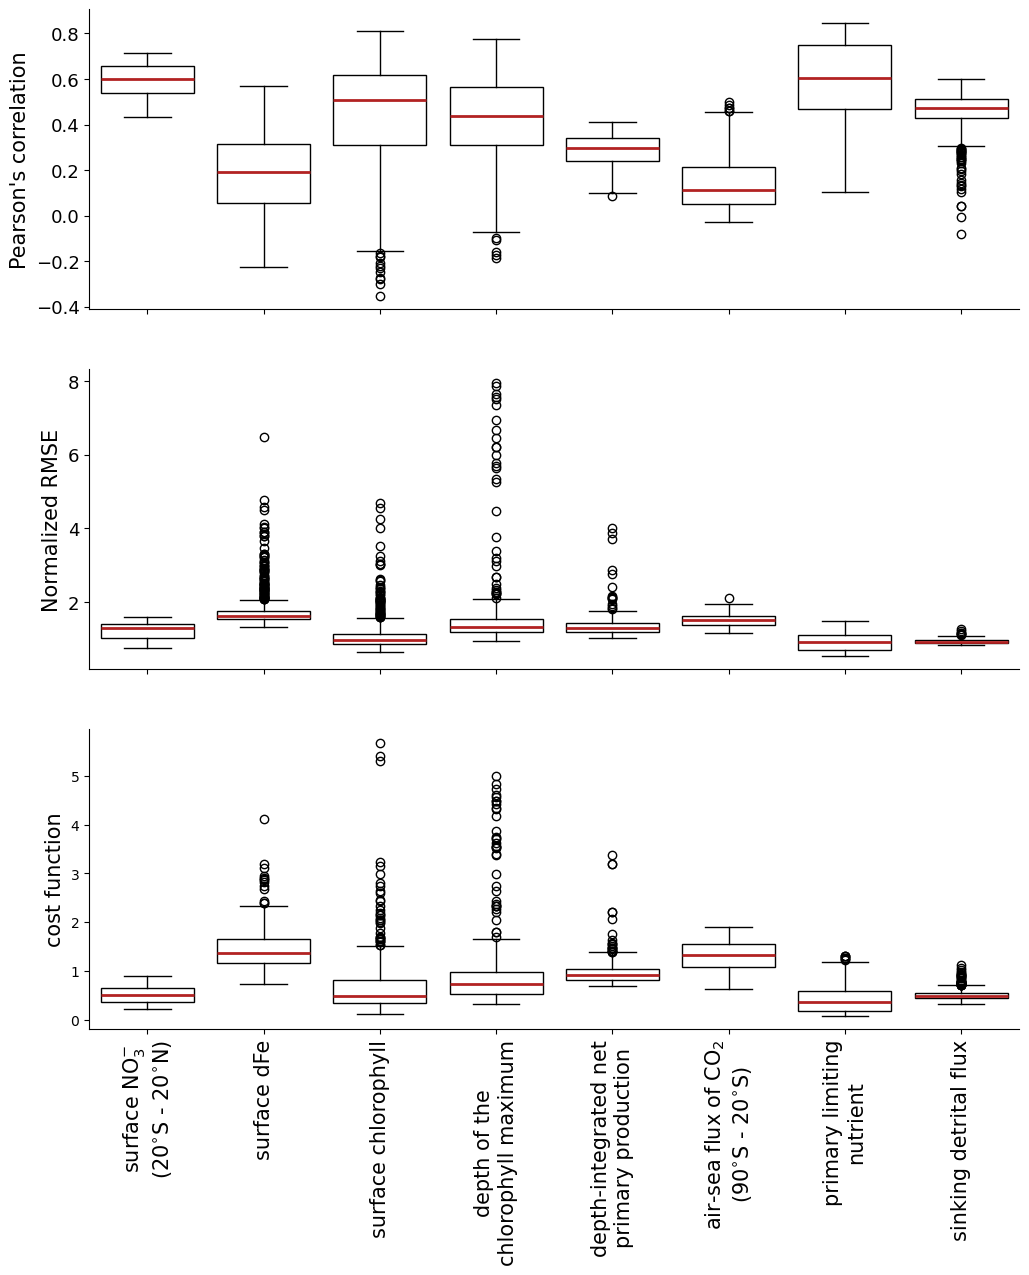

In [5]:
fstic = 13
fslab = 15

fig = plt.figure(figsize=(12,15))
gs = GridSpec(3,1)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[2,0])
ax1.spines[['top','right']].set_visible(False)
ax2.spines[['top','right']].set_visible(False)
ax3.spines[['top','right']].set_visible(False)
ax1.tick_params(labelsize=fstic, labelbottom=False)
ax2.tick_params(labelsize=fstic, labelbottom=False)
ax2.tick_params(labelsize=fstic)

box1 = ax1.boxplot(corr, positions=np.arange(0,8,1), widths=0.8, patch_artist=True)
box2 = ax2.boxplot(nrmse, positions=np.arange(0,8,1), widths=0.8, patch_artist=True)
box3 = ax3.boxplot(cost, positions=np.arange(0,8,1), widths=0.8, patch_artist=True)

# Apply colors to each box
for patch in box1['boxes']:
    patch.set_facecolor('w')
for patch in box2['boxes']:
    patch.set_facecolor('w')
for patch in box3['boxes']:
    patch.set_facecolor('w')
for median in box1['medians']:
    median.set(color='firebrick', linewidth=2)
for median in box2['medians']:
    median.set(color='firebrick', linewidth=2)
for median in box3['medians']:
    median.set(color='firebrick', linewidth=2)

ax1.set_xlim(-0.5,7.5)
ax2.set_xlim(-0.5,7.5)
ax3.set_xlim(-0.5,7.5)

#ax2.set_yscale('log')

ax1.set_ylabel("Pearson's correlation", fontsize=fslab)
ax2.set_ylabel("Normalized RMSE", fontsize=fslab)
ax3.set_ylabel("cost function", fontsize=fslab)

targets = ['surface NO$_3^{-}$\n(20$^{\circ}$S - 20$^{\circ}$N)', 'surface dFe', 'surface chlorophyll', 'depth of the\nchlorophyll maximum', \
           'depth-integrated net\nprimary production', 'air-sea flux of CO$_2$\n(90$^{\circ}$S - 20$^{\circ}$S)', \
           'primary limiting\nnutrient', 'sinking detrital flux']
ax3.set_xticks(np.arange(0,8,1), targets, fontsize=fslab, rotation=90)

plt.subplots_adjust(bottom=0.2)

os.chdir(wrkdir)
fig.savefig("sensitivity_analysis_corr_nrmse_costfunction.png", dpi=300)
fig.savefig("sensitivity_analysis_corr_nrmse_costfunction.pdf", dpi=300)
#fig.savefig("sensitivity_analysis_corr_nrmse_costfunction_transparent.png", dpi=300, transparent=True)


### Train a Gaussian Process Regression model on the output

In [6]:
### format the input data to the GPR model
X.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

tarcols = nrmse.columns
tarcols

Y = np.zeros((512, len(tarcols)))
for i, target in enumerate(tarcols):
    Y[:,i] = rmse[target]
    # Normalising RMSE values (RMSE - min(RMSE)/max(RMSE) - min(RMSE))
    Y[:,i]=(Y[:,i]-Y[:,i].min())/(Y[:,i].max()-Y[:,i].min())


In [8]:
%%time

import warnings
warnings.filterwarnings('ignore')

n_vars = 8
n_params = 14
N = 512

fold = int(8)
fold_size = int(N/fold)
GPR_score = np.zeros((fold,n_vars))
Y_PRED = np.zeros((N,n_vars))
Y_TRUE = np.zeros((N,n_vars))

for i in range(n_vars):
    print(i)
    '''
    kernel function for your Gaussian process regression
    kernel = constant kernel (adds a constant value to the diagonal of the covariance matrix) +
    Matern kernel (parameterized with a length scale of 25 dimensions (25 features) with each feature having a length scale of 1 and nu of 1.5) +
    white noise to the covariance matrix with a very small noise level
    '''
    #kernel = ConstantKernel()+1.0**2 * RBF(length_scale=np.ones((13,1)))+WhiteKernel(noise_level=1e-10)
    kernel = ConstantKernel()+Matern(length_scale=np.ones((n_params,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    '''
    Passing Matern kernel and setting 10 restarts of the optimizer for finding the kernel's parameters
    that maximize the log-marginal-likelihood
    '''
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    y_pred = np.zeros(1)
    y_true = np.zeros(1)
    for k in range(fold):
        X_train = pd.concat([X.iloc[0:k*fold_size,:],X.iloc[(k+1)*fold_size:,:]],axis=0)
        X_test = X.iloc[k*fold_size:(k+1)*fold_size,:]
        y_train = np.concatenate([Y[0:k*fold_size,i],Y[(k+1)*fold_size:,i]],axis=0)
        y_test = Y[k*fold_size:(k+1)*fold_size,i]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        GPR_score[k,i] = r2_score(y_test,y_hat)
        y_pred = np.append(y_pred,y_hat,axis=0)
        y_true = np.append(y_true,y_test,axis=0)
    Y_PRED[:,i] = y_pred[1:]
    Y_TRUE[:,i] = y_true[1:]
    y_pred = pd.DataFrame(y_pred[1:])
    y_true = pd.DataFrame(y_true[1:])
    print(targets[i],r2_score(y_true,y_pred))


0
surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) 0.8299812679544001
1
surface dFe 0.8007726844348603
2
surface chlorophyll 0.8657192828673028
3
depth of the
chlorophyll maximum 0.8432718130254516
4
depth-integrated net
primary production 0.7493483132542795
5
air-sea flux of CO$_2$
(90$^{\circ}$S - 20$^{\circ}$S) 0.9126250049394425
6
primary limiting
nutrient 0.756569151211256
7
sinking detrital flux 0.8741313762235852
CPU times: user 14min 42s, sys: 4min 43s, total: 19min 25s
Wall time: 19min 25s


## plot

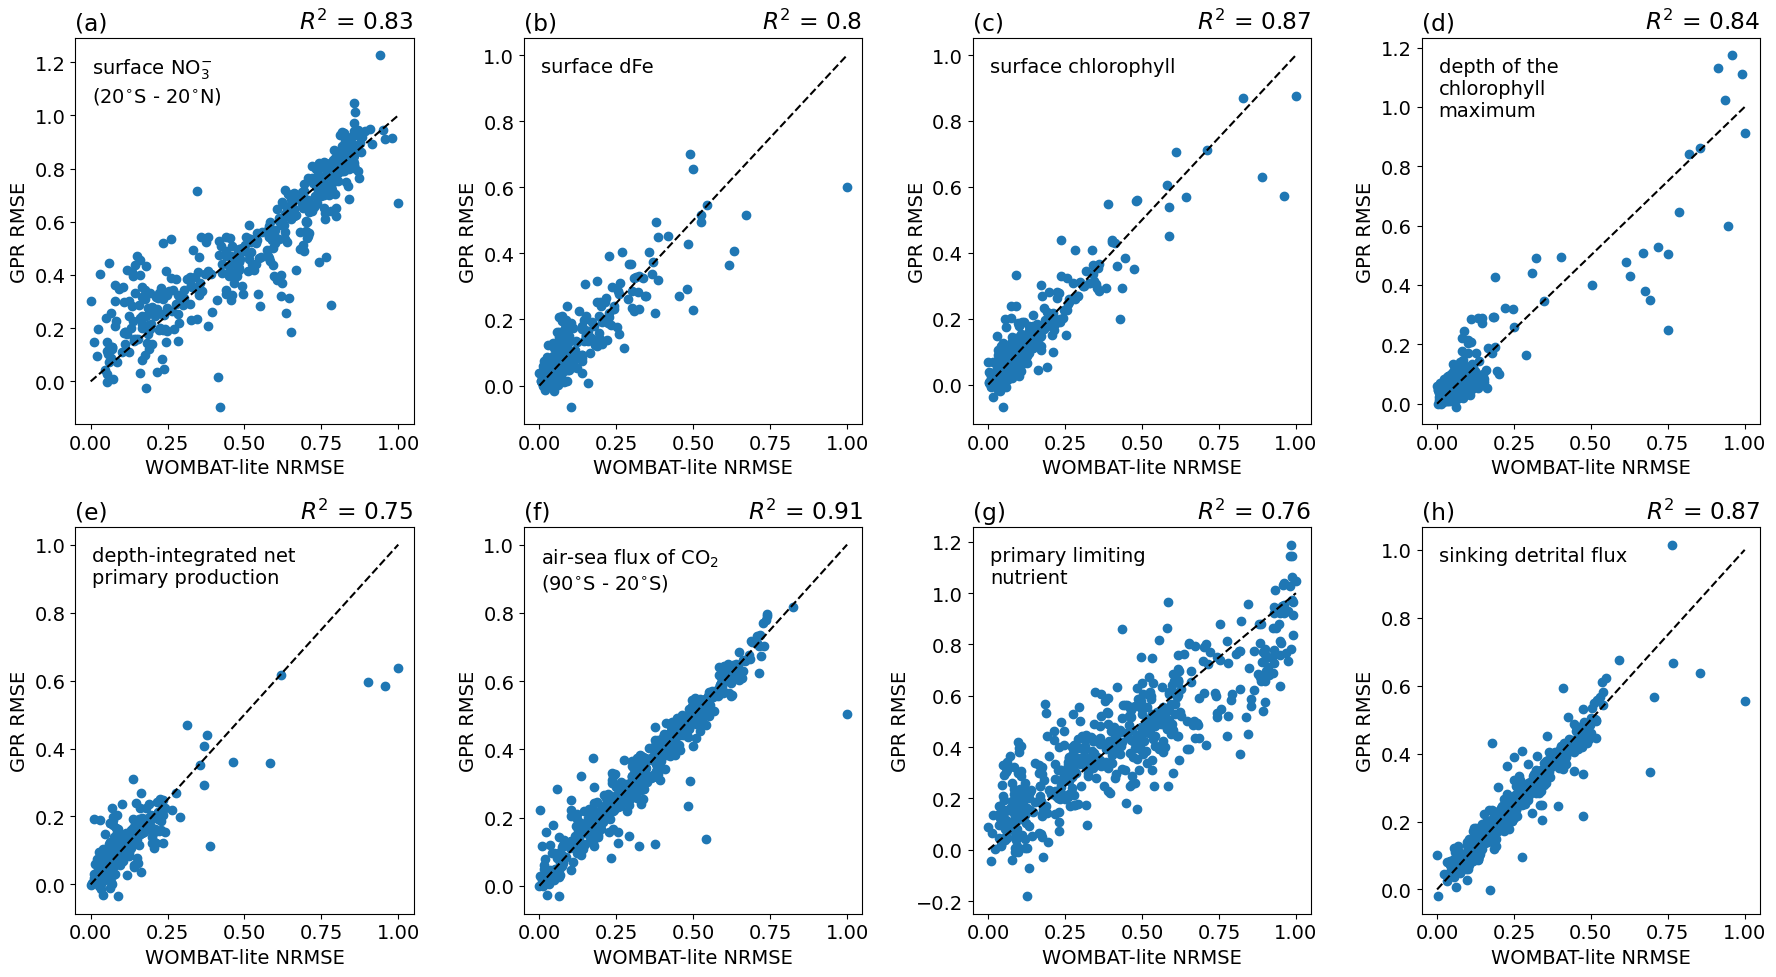

In [9]:

fig = plt.figure(figsize=(18,10))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']

targets = ['surface NO$_3^{-}$\n(20$^{\circ}$S - 20$^{\circ}$N)', 'surface dFe', 'surface chlorophyll', 'depth of the\nchlorophyll\nmaximum', \
           'depth-integrated net\nprimary production', 'air-sea flux of CO$_2$\n(90$^{\circ}$S - 20$^{\circ}$S)', \
           'primary limiting\nnutrient', 'sinking detrital flux']

for i in range(8):
    #ax = fig.add_subplot(2,3,i+1)
    ax = fig.add_subplot(2,4,i+1)
    ax.plot((np.min(Y_TRUE[:,i]),np.max(Y_TRUE[:,i])), (np.min(Y_TRUE[:,i]), np.max(Y_TRUE[:,i])), 'k--')
    ax.scatter(Y_TRUE[:,i],Y_PRED[:,i])
    ax.set_title(abc[i], loc='left')
    ax.text(0.05,0.95, targets[i], va='top', ha='left', transform=ax.transAxes)
    ax.set_title('$R^2$ = '+str(round(r2_score(Y_TRUE[:,i],Y_PRED[:,i]),2)),
               loc='right')
    ax.set_xlabel(r'WOMBAT-lite NRMSE')
    ax.set_ylabel('GPR RMSE')
    #ax.set_xlim(0,1)
    #ax.set_ylim(0,1)

plt.tight_layout()
fig.savefig('sensitivity_analysis_GPRaccuracy_RMSEnormRange_512.png', dpi=300,bbox_inches='tight')


### calculate the GPR accuracy at different numbers of experimental samples

In [10]:
%%time
import warnings
warnings.filterwarnings('ignore')
GPR_score = np.zeros((8,3,8))
N = [128,256,512]
for i in range(8):
    #kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((25,1))) + WhiteKernel(noise_level=1e-10)
    kernel = ConstantKernel()+Matern(length_scale=np.ones((n_params,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    for j in range(3):
        n = int(N[j]/8)
        y_pred = np.zeros(1)
        y_true = np.zeros(1)
        for k in range(8):
            X_train = pd.concat([X.iloc[0:k*n,:],X.iloc[(k+1)*n:N[j],:]],axis=0)
            X_test = X.iloc[k*n:(k+1)*n,:]
            y_train = np.concatenate([Y[0:k*n,i],Y[(k+1)*n:N[j],i]],axis=0)
            y_test = Y[k*n:(k+1)*n,i]
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            GPR_score[i,j,k] = r2_score(y_test,y_hat)
            y_pred = np.append(y_pred,y_hat,axis=0)
            y_true = np.append(y_true,y_test,axis=0)
        y_pred = pd.DataFrame(y_pred[1:])
        y_true = pd.DataFrame(y_true[1:])
        print(targets[i],'N=',N[j],r2_score(y_true,y_pred))


surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) N= 128 0.6859637454840548
surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) N= 256 0.6771182555283038
surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) N= 512 0.8299812679544001
surface dFe N= 128 0.5479262987641895
surface dFe N= 256 0.6567074901825538
surface dFe N= 512 0.8007726844348603
surface chlorophyll N= 128 0.3120112426081968
surface chlorophyll N= 256 0.7561016418986377
surface chlorophyll N= 512 0.8657192828673028
depth of the
chlorophyll
maximum N= 128 0.7385563081867774
depth of the
chlorophyll
maximum N= 256 0.8370380801481863
depth of the
chlorophyll
maximum N= 512 0.843005336324819
depth-integrated net
primary production N= 128 0.22041701150915904
depth-integrated net
primary production N= 256 0.23634793799691722
depth-integrated net
primary production N= 512 0.7493483132542795
air-sea flux of CO$_2$
(90$^{\circ}$S - 20$^{\circ}$S) N= 128 0.8557496605908456
air-sea flux of CO$_2$
(90$^{\circ}$S - 20$^{\circ}$S) N= 25

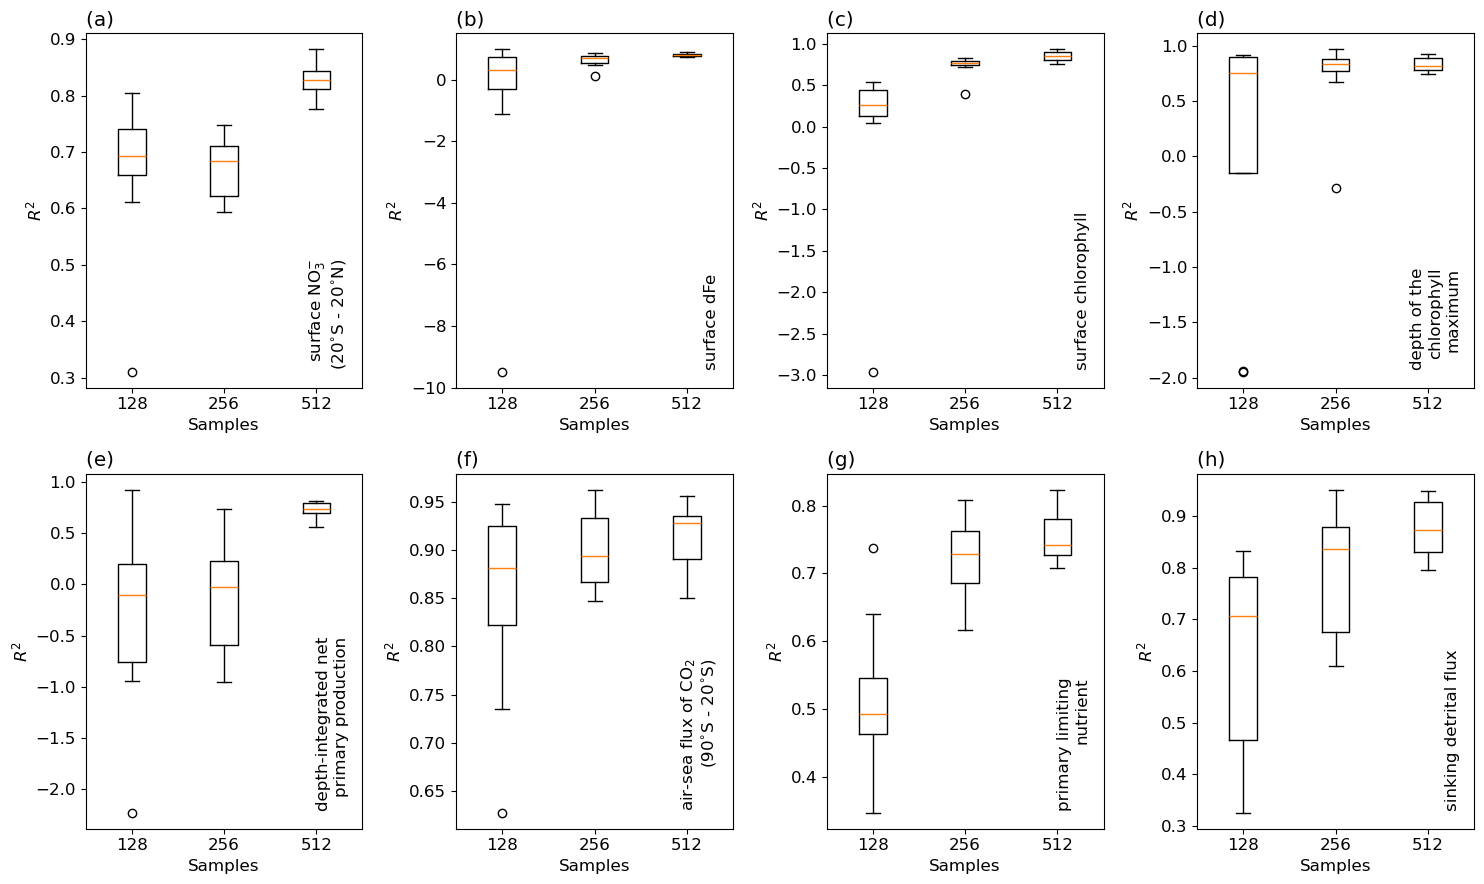

In [11]:
fig = plt.figure(figsize=(15,9))
plt.rc('font', size=12)    # fontsize of the all text
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('xtick', labelsize=12)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
for i in range(8):
    #axs = fig.add_subplot(2,3,i+1)
    axs = fig.add_subplot(2,4,i+1)
    axs.boxplot(GPR_score[i,0:3,:].T)
    axs.set_title(abc[i], loc='left')
    axs.text(0.95,0.05, targets[i], va='bottom', ha='right', transform=axs.transAxes, rotation=90)
    axs.set_ylabel('$R^2$')
    axs.set_xlabel('Samples')
    axs.set_xticklabels(['128','256','512'])
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.tight_layout()
fig.savefig('sensitivity_analysis_GPRsensitivity_RMSEnormRange.png', dpi=300,bbox_inches='tight')

### Do Sobol' sensitivity analysis

In [12]:
%%time
problem = {
    'num_vars': 14,
    'names': ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10', 'P11', 'P12', 'P13', 'P14'],
    'bounds': [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]       
}
param_values = saltelli.sample(problem, 1024, calc_second_order=True)
print(param_values.shape, max(param_values[:,0]))


(30720, 14) 0.99951171875
CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 247 ms


In [ ]:
%%time
n_vars = 8
s1 = np.zeros((n_vars,n_params))
st = np.zeros((n_vars,n_params))
s2 = np.zeros((n_vars,n_params,n_params))
for i in range(n_vars):
    y = Y[:,i]
    #kernel = ConstantKernel()+1.0**2 * RBF(length_scale=np.ones((25,1)))+WhiteKernel(noise_level=1e-5)
    kernel = ConstantKernel()+Matern(length_scale=np.ones((n_params,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    model.fit(X, y)
    y_hat = model.predict(param_values)
    Si = sobol.analyze(problem, y_hat, parallel=True, n_processors= 2, print_to_console=False)
    print(Si['ST'])
    st[i,...] = Si['ST']
    s1[i,...] = Si['S1']
    s2[i,...] = Si['S2']

[2.16095888e-01 3.63001244e-02 3.58460046e-01 7.66445569e-04
 1.33499168e-02 2.16153158e-15 5.88984973e-03 1.95062351e-15
 2.17956230e-01 3.30185972e-01 4.35400852e-01 4.19123993e-14
 1.22242190e-03 3.35379468e-15]
[1.25302199e-01 9.45148520e-03 2.07349513e-01 3.52956227e-03
 5.50018886e-15 3.52849526e-15 1.50875344e-16 4.51096733e-15
 1.14024332e-01 1.74863255e-01 4.25854785e-01 2.83770052e-02
 1.99281434e-03 7.25465787e-01]
[1.14922685e-01 4.22414835e-01 1.43485716e-01 1.01180115e-01
 4.70574010e-04 3.13578952e-03 3.96208814e-03 1.76667555e-14
 3.75226302e-02 2.39337508e-01 5.59020956e-01 7.37364269e-16
 4.25399028e-15 1.46077043e-01]
[4.26301814e-01 4.13838419e-03 9.16946294e-01 2.36353488e-04
 1.79774027e-05 1.36853101e-11 1.58362947e-03 3.46390103e-10
 3.15697875e-01 3.77112379e-03 1.50729899e-03 2.14754829e-03
 1.93140802e-04 2.74923001e-11]
[7.01096738e-01 4.16604698e-01 1.57371508e-01 6.13188160e-02
 4.69873199e-03 1.06935255e-15 2.16883167e-02 1.97721744e-13
 5.41379906e-02 2.

In [15]:
df = pd.DataFrame(data=st,
                    index=targets,
                    columns=problem['names'])
df_t = df.T
df_t = (df_t-df_t.min())/(df_t.max()-df_t.min())
df = df_t.T
df


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14
surface NO$_3^{-}$\n(20$^{\circ}$S - 20$^{\circ}$N),0.496315,0.083372,0.823287,1.760322e-03,3.066121e-02,4.843998e-16,1.352742e-02,0.000000e+00,0.500588,0.758349,1.000000,9.178157e-14,2.807578e-03,3.222711e-15
surface dFe,0.172720,0.013028,0.285816,4.865236e-03,7.373626e-15,4.655795e-15,0.000000e+00,6.010059e-15,0.157174,0.241036,0.587009,3.911557e-02,2.746945e-03,1.000000e+00
surface chlorophyll,0.205578,0.755633,0.256673,1.809952e-01,8.417824e-04,5.609431e-03,7.087549e-03,3.028400e-14,0.067122,0.428137,1.000000,0.000000e+00,6.290687e-15,2.613087e-01
depth of the\nchlorophyll\nmaximum,0.464915,0.004513,1.000000,2.577615e-04,1.960572e-05,0.000000e+00,1.727069e-03,3.628400e-10,0.344293,0.004113,0.001644,2.342065e-03,2.106348e-04,1.505758e-11
depth-integrated net\nprimary production,1.000000,0.594219,0.224465,8.746128e-02,6.701974e-03,1.435076e-15,3.093484e-02,2.819276e-13,0.077219,0.341650,0.931835,0.000000e+00,1.029236e-15,2.257596e-01
air-sea flux of CO$_2$\n(90$^{\circ}$S - 20$^{\circ}$S),1.000000,0.386488,0.468999,6.821831e-04,7.370689e-04,8.515567e-15,1.175114e-03,6.478134e-05,0.020917,0.284947,0.485174,0.000000e+00,7.033529e-03,1.105599e-01
primary limiting\nnutrient,0.829064,1.000000,0.921368,1.200488e-02,1.134646e-02,3.307735e-18,3.708947e-03,1.839080e-16,0.328939,0.401330,0.905676,0.000000e+00,1.569259e-16,6.154231e-01
sinking detrital flux,0.815038,0.183719,0.554737,1.383320e-13,0.000000e+00,6.563771e-15,1.711551e-14,3.913422e-15,0.043092,1.000000,0.307326,5.363386e-15,1.957206e-13,9.013286e-02


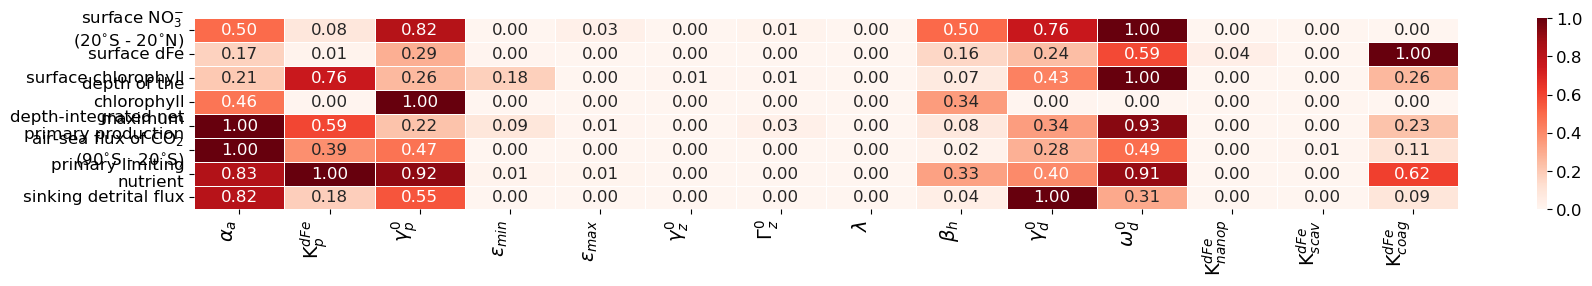

In [23]:
fig = plt.figure(figsize=(18,3))
gs = GridSpec(1,1)

ax = plt.subplot(gs[0])
ax = sns.heatmap(df,cmap="Reds",linewidths=.5, annot=True,fmt=".2f")
plt.xticks(rotation='horizontal')
ax.set_xticklabels([r'$\alpha_{a}$', r'K$^{dFe}_{p}$', r'$\gamma^{0}_{p}$', 
                    r'$\epsilon_{min}$', r'$\epsilon_{max}$', r'$\gamma^{0}_{z}$', 
                    r'$\Gamma^{0}_{z}$', r'$\lambda$', r'$\beta_{h}$', 
                    r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$',
                    r'K$^{dFe}_{nanop}$', r'K$^{dFe}_{scav}$', r'K$^{dFe}_{coag}$'], 
                   rotation=90, fontsize=14, ha='right')
plt.tight_layout()


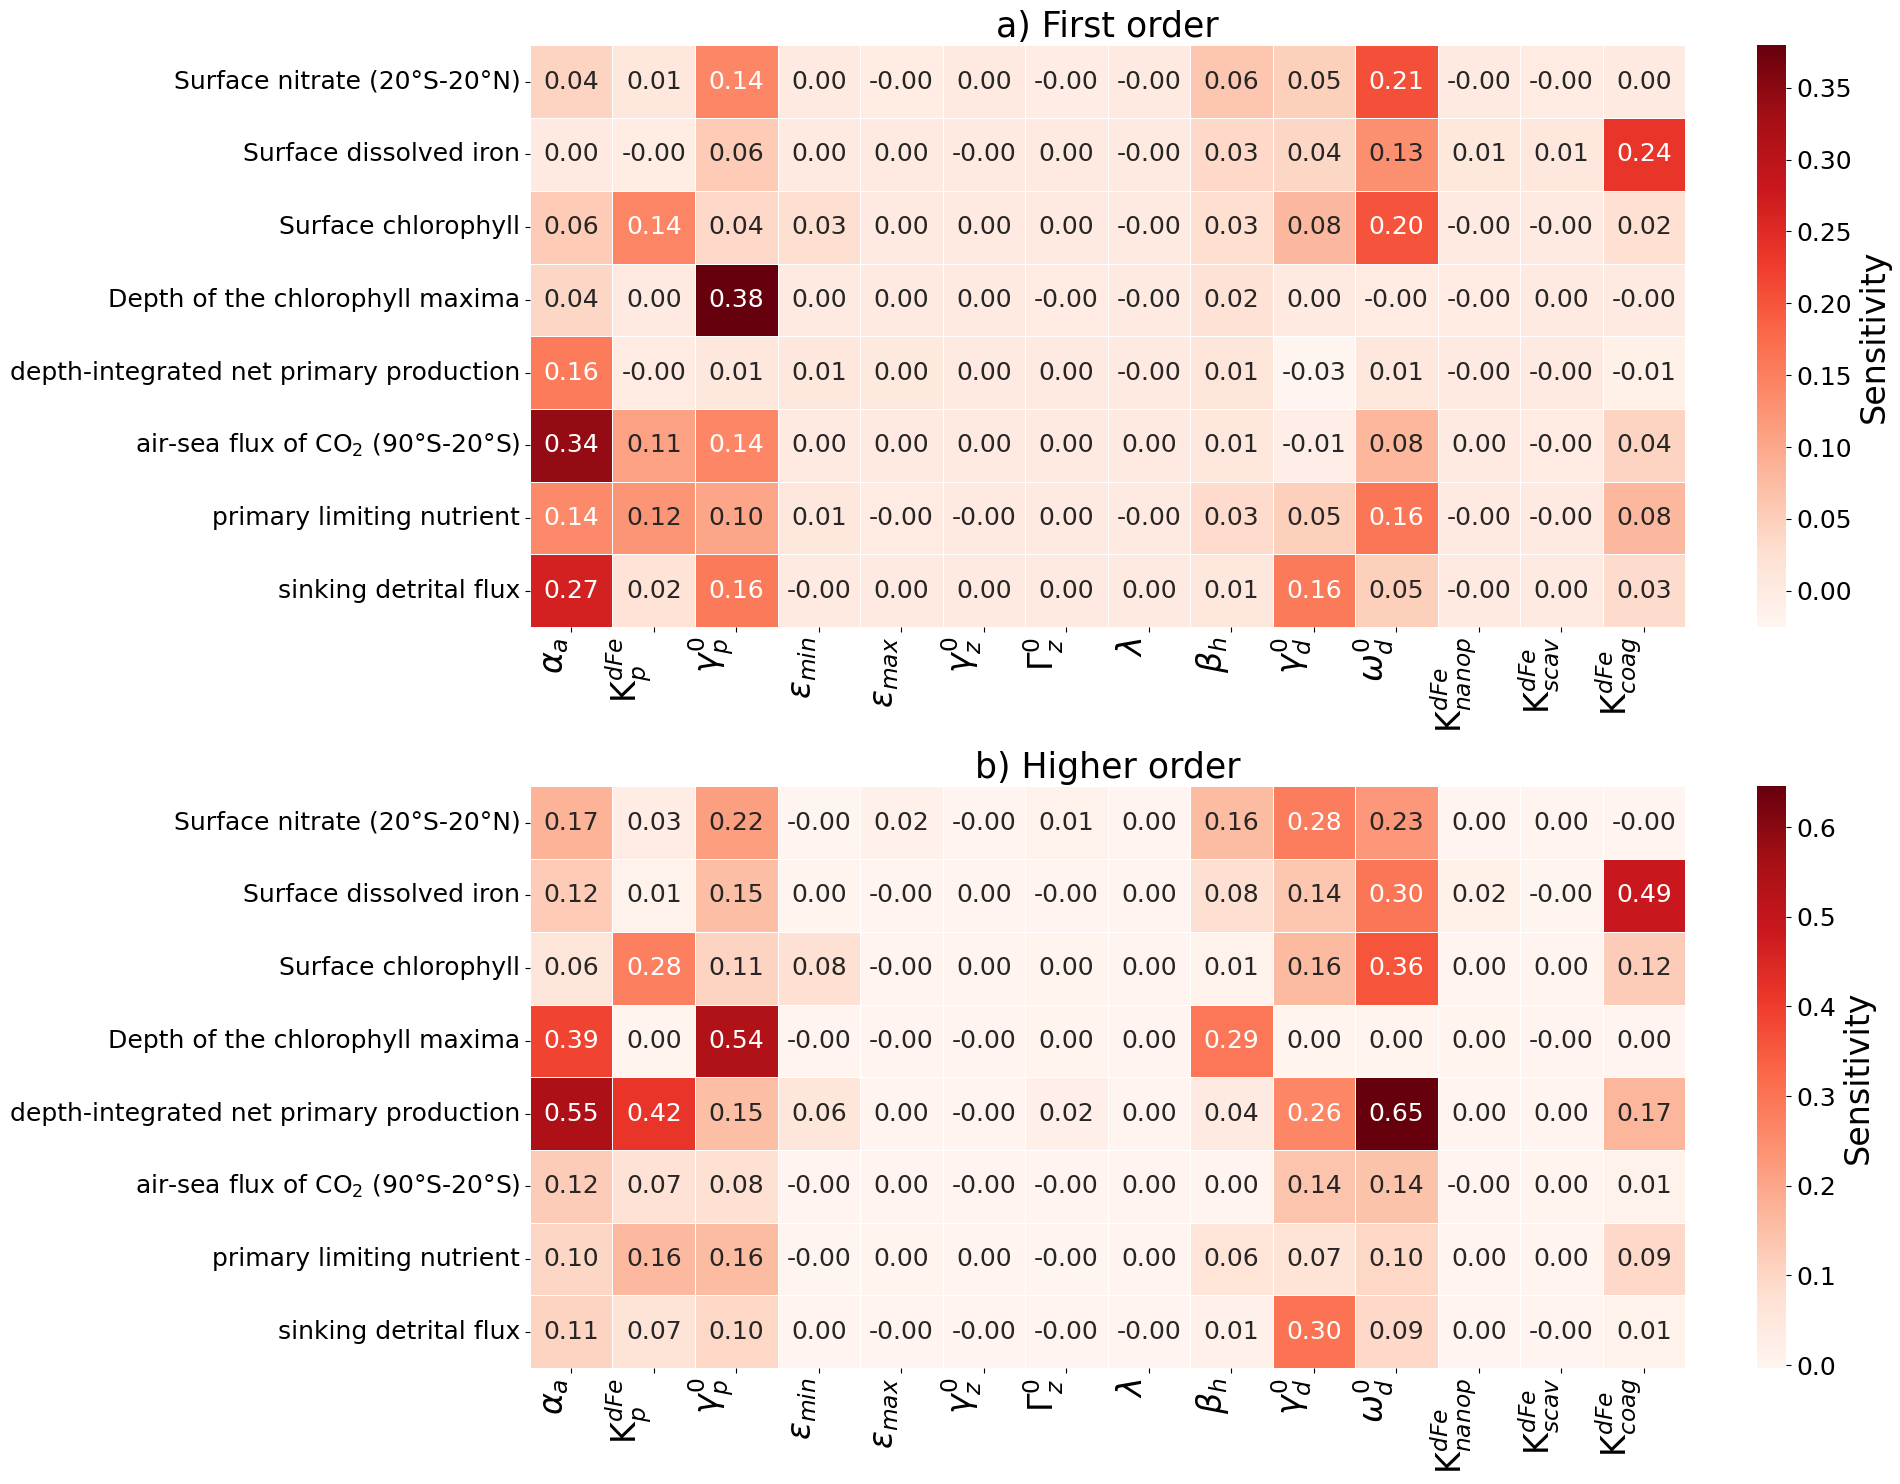

In [40]:
var_names = [
    'Surface nitrate (20°S-20°N)', 
    'Surface dissolved iron', 
    'Surface chlorophyll', 
    'Depth of the chlorophyll maxima',
    'depth-integrated net primary production', 
    'air-sea flux of CO$_{2}$ (90°S-20°S)', 
    'primary limiting nutrient', 
    'sinking detrital flux'
]

# First dataset processing
df1 = pd.DataFrame(data=s1, index=var_names, columns=problem['names'])
df_t1 = df1.T
#df_t1 = (df_t1 - df_t1.min()) / (df_t1.max() - df_t1.min())
df1 = df_t1.T

# Second dataset processing
df2 = pd.DataFrame(data=(st - s1), index=var_names, columns=problem['names'])
df_t2 = df2.T
#df_t2 = (df_t2 - df_t2.min()) / (df_t2.max() - df_t2.min())
df2 = df_t2.T

# Common x-tick labels
xtick_labels = [r'$\alpha_{a}$', r'K$^{dFe}_{p}$', r'$\gamma^{0}_{p}$', 
                r'$\epsilon_{min}$', r'$\epsilon_{max}$', r'$\gamma^{0}_{z}$', 
                r'$\Gamma^{0}_{z}$', r'$\lambda$', r'$\beta_{h}$', 
                r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$',
                r'K$^{dFe}_{nanop}$', r'K$^{dFe}_{scav}$', r'K$^{dFe}_{coag}$']

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

# Plot first heatmap (subplot a)
hmap1 = sns.heatmap(df1, cmap="Reds", linewidths=0.5, annot=True, fmt=".2f", ax=axes[0], annot_kws={"size": 18})
axes[0].set_xticklabels(xtick_labels, rotation=90, fontsize=18, ha='right')
axes[0].set_title('a) First order', fontsize=25)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=18)
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=24)

# Plot second heatmap (subplot b)
hmap2 = sns.heatmap(df2, cmap="Reds", linewidths=0.5, annot=True, fmt=".2f", ax=axes[1], annot_kws={"size": 18})
axes[1].set_xticklabels(xtick_labels, rotation=90, fontsize=18, ha='right')
axes[1].set_title('b) Higher order', fontsize=25)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=18)
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=24)

cbar1 = hmap1.collections[0].colorbar
cbar2 = hmap2.collections[0].colorbar
cbar1.set_label('Sensitivity', fontsize=24)
cbar1.ax.tick_params(labelsize=18)
cbar2.set_label('Sensitivity', fontsize=24)
cbar2.ax.tick_params(labelsize=18)

# Adjust layout
plt.tight_layout()
fig.savefig('sensitivity_analysis_SAresult_RMSEnormRange.png', dpi=300,bbox_inches='tight')
fig.savefig('sensitivity_analysis_SAresult_RMSEnormRange.pdf', dpi=300,bbox_inches='tight')

## Optimisation

In [44]:
# Use the same parameter set
X_O = X

tarcols = cost.columns
tarcols

# Use the cost function defined earlier == (1-r)*NRMSE
Y_O = np.zeros((512, len(tarcols)))
for i, target in enumerate(tarcols):
    Y_O[:,i] = cost[target]
    # Normalising Error values (Error - min(Error)/max(Error) - min(Error))
    Y_O[:,i]=(Y_O[:,i]-Y_O[:,i].min())/(Y_O[:,i].max()-Y_O[:,i].min())


### Train the GPR on the cost function from the 512 model samples

In [46]:
%%time
import warnings
warnings.filterwarnings('ignore')

n_vars = 8
n_params = 14
N = 512

fold = int(8)
fold_size = int(N/fold)
GPR_score = np.zeros((fold,n_vars))
Y_PRED = np.zeros((N,n_vars))
Y_TRUE = np.zeros((N,n_vars))

for i in range(n_vars):
    '''
    kernel function for your Gaussian process regression
    kernel = constant kernel (adds a constant value to the diagonal of the covariance matrix) +
    Matern kernel (parameterized with a length scale of 13 dimensions (13 features) with each feature having a length scale of 1 and nu of 1.5) +
    white noise to the covariance matrix with a very small noise level
    '''
    kernel = ConstantKernel()+Matern(length_scale=np.ones((n_params,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    '''
    Passing Matern kernel and setting 10 restarts of the optimizer for finding the kernel's parameters
    that maximize the log-marginal-likelihood
    '''
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    y_pred = np.zeros(1)
    y_true = np.zeros(1)
    for k in range(fold):
        X_train = pd.concat([X_O.iloc[0:k*fold_size,:],X_O.iloc[(k+1)*fold_size:,:]],axis=0)
        X_test = X_O.iloc[k*fold_size:(k+1)*fold_size,:]
        y_train = np.concatenate([Y_O[0:k*fold_size,i],Y_O[(k+1)*fold_size:,i]],axis=0)
        y_test = Y_O[k*fold_size:(k+1)*fold_size,i]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        GPR_score[k,i] = r2_score(y_test,y_hat)
        y_pred = np.append(y_pred,y_hat,axis=0)
        y_true = np.append(y_true,y_test,axis=0)
    Y_PRED[:,i] = y_pred[1:]
    Y_TRUE[:,i] = y_true[1:]
    y_pred = pd.DataFrame(y_pred[1:])
    y_true = pd.DataFrame(y_true[1:])
    print(targets[i],r2_score(y_true,y_pred))

surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) 0.8668278596864132
surface dFe 0.8120063239457254
surface chlorophyll 0.7803454106710601
depth of the
chlorophyll
maximum 0.852540473696257
depth-integrated net
primary production 0.7287879112513185
air-sea flux of CO$_2$
(90$^{\circ}$S - 20$^{\circ}$S) 0.9583912192321031
primary limiting
nutrient 0.7455921395482428
sinking detrital flux 0.9081913163373974
CPU times: user 15min 32s, sys: 409 ms, total: 15min 33s
Wall time: 15min 33s


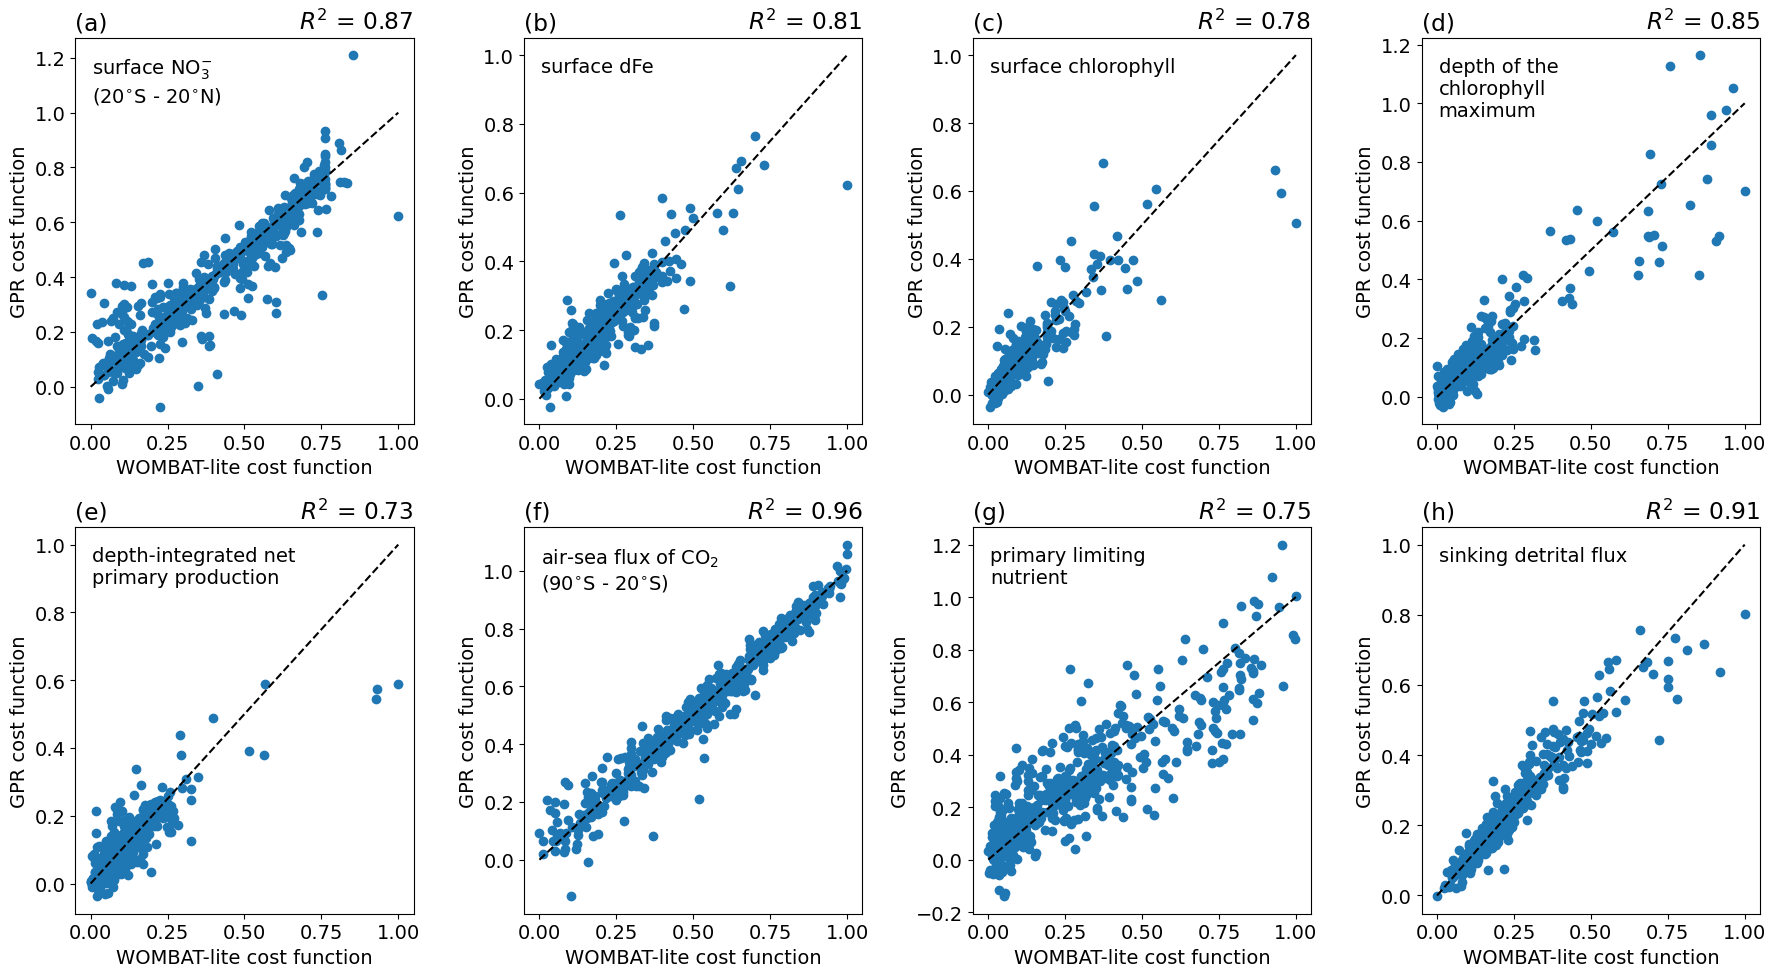

In [48]:
fig = plt.figure(figsize=(18,10))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']

targets = ['surface NO$_3^{-}$\n(20$^{\circ}$S - 20$^{\circ}$N)', 'surface dFe', 'surface chlorophyll', 'depth of the\nchlorophyll\nmaximum', \
           'depth-integrated net\nprimary production', 'air-sea flux of CO$_2$\n(90$^{\circ}$S - 20$^{\circ}$S)', \
           'primary limiting\nnutrient', 'sinking detrital flux']

for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.plot((np.min(Y_TRUE[:,i]),np.max(Y_TRUE[:,i])), (np.min(Y_TRUE[:,i]), np.max(Y_TRUE[:,i])), 'k--')
    ax.scatter(Y_TRUE[:,i],Y_PRED[:,i])
    ax.set_title(abc[i], loc='left')
    ax.text(0.05,0.95, targets[i], va='top', ha='left', transform=ax.transAxes)
    ax.set_title('$R^2$ = '+str(round(r2_score(Y_TRUE[:,i],Y_PRED[:,i]),2)),
               loc='right')
    ax.set_xlabel(r'WOMBAT-lite cost function')
    ax.set_ylabel('GPR cost function')

plt.tight_layout()
fig.savefig('optimisation_GPRaccuracy_costfunction_512.png', dpi=300,bbox_inches='tight')


### calculate the GPR accuracy at different numbers of experimental samples

In [49]:
%%time
import warnings
warnings.filterwarnings('ignore')
GPR_score = np.zeros((8,3,8))
N = [128,256,512]
for i in range(8):
    #kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((25,1))) + WhiteKernel(noise_level=1e-10)
    kernel = ConstantKernel()+Matern(length_scale=np.ones((n_params,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    for j in range(3):
        n = int(N[j]/8)
        y_pred = np.zeros(1)
        y_true = np.zeros(1)
        for k in range(8):
            X_train = pd.concat([X.iloc[0:k*n,:],X.iloc[(k+1)*n:N[j],:]],axis=0)
            X_test = X.iloc[k*n:(k+1)*n,:]
            y_train = np.concatenate([Y[0:k*n,i],Y[(k+1)*n:N[j],i]],axis=0)
            y_test = Y[k*n:(k+1)*n,i]
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            GPR_score[i,j,k] = r2_score(y_test,y_hat)
            y_pred = np.append(y_pred,y_hat,axis=0)
            y_true = np.append(y_true,y_test,axis=0)
        y_pred = pd.DataFrame(y_pred[1:])
        y_true = pd.DataFrame(y_true[1:])
        print(targets[i],'N=',N[j],r2_score(y_true,y_pred))


surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) N= 128 0.6859637454840548
surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) N= 256 0.6771182555283038
surface NO$_3^{-}$
(20$^{\circ}$S - 20$^{\circ}$N) N= 512 0.8299844854452466
surface dFe N= 128 0.5479262987641895
surface dFe N= 256 0.6567060498516004
surface dFe N= 512 0.8007726844348603
surface chlorophyll N= 128 0.31201238542299936
surface chlorophyll N= 256 0.7561016418986377
surface chlorophyll N= 512 0.8657181166283824
depth of the
chlorophyll
maximum N= 128 0.7385563081867774
depth of the
chlorophyll
maximum N= 256 0.8370380801481863
depth of the
chlorophyll
maximum N= 512 0.8433086133277565
depth-integrated net
primary production N= 128 0.22041701150915904
depth-integrated net
primary production N= 256 0.23634793799691722
depth-integrated net
primary production N= 512 0.7493483132542795
air-sea flux of CO$_2$
(90$^{\circ}$S - 20$^{\circ}$S) N= 128 0.8557196979805017
air-sea flux of CO$_2$
(90$^{\circ}$S - 20$^{\circ}$S) N= 

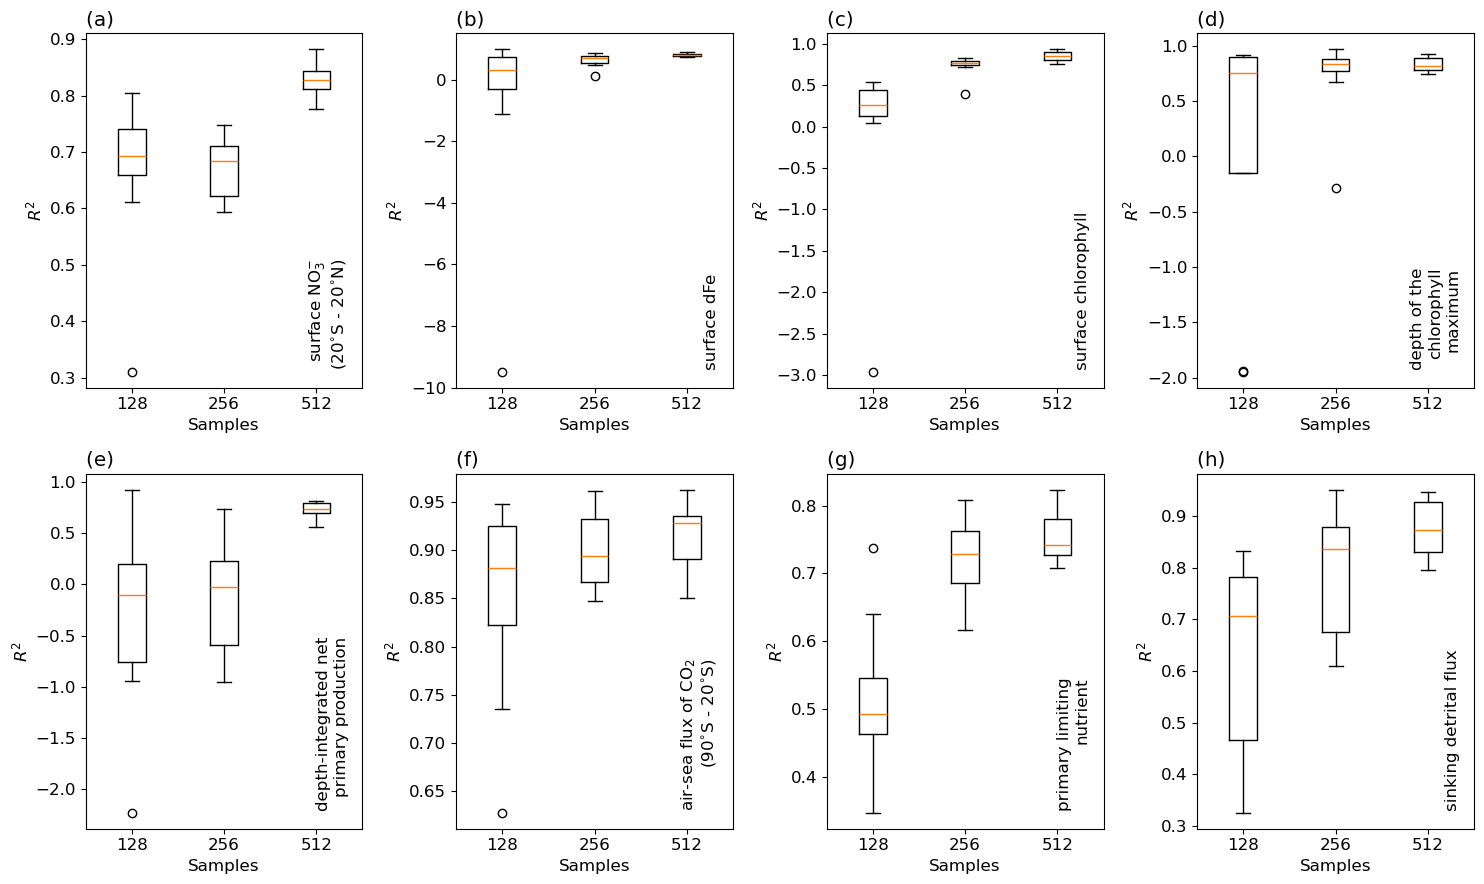

In [50]:
fig = plt.figure(figsize=(15,9))
plt.rc('font', size=12)    # fontsize of the all text
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('xtick', labelsize=12)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
for i in range(8):
    #axs = fig.add_subplot(2,3,i+1)
    axs = fig.add_subplot(2,4,i+1)
    axs.boxplot(GPR_score[i,0:3,:].T)
    axs.set_title(abc[i], loc='left')
    axs.text(0.95,0.05, targets[i], va='bottom', ha='right', transform=axs.transAxes, rotation=90)
    axs.set_ylabel('$R^2$')
    axs.set_xlabel('Samples')
    axs.set_xticklabels(['128','256','512'])
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.tight_layout()
fig.savefig('optimisation_GPRsensitivity_costfunction.png', dpi=300,bbox_inches='tight')


### save the GPR models to my home directory for ease of use later

In [51]:
%%time
for i in range(len(tarcols)):
    y = Y_O[:,i]
    kernel = ConstantKernel()+Matern(length_scale=np.ones((n_params,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    model.fit(X_O, y)
    filename = f'GPR_{tarcols[i]}.joblib'
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")


Model saved to GPR_surno3.joblib
Model saved to GPR_surfer.joblib
Model saved to GPR_surchl.joblib
Model saved to GPR_chmaxz.joblib
Model saved to GPR_intnpp.joblib
Model saved to GPR_fgco2_.joblib
Model saved to GPR_phylim.joblib
Model saved to GPR_pocsin.joblib
CPU times: user 2min 51s, sys: 47.6 s, total: 3min 39s
Wall time: 3min 39s


### load the save GPR models

In [57]:
os.chdir(wrkdir)
print(os.getcwd())

tarcols = ['surno3', 'surfer', 'surchl', 'chmaxz', 'intnpp', 'fgco2_', 'phylim', 'pocsin']
for i, var_name in enumerate(tarcols):
    
    # Load the saved model 
    model = joblib.load(f'GPR_{var_name}.joblib')
    
    # Predict using the fitted model
    predictions = model.predict(X_O)
    
    # Print the minimum and maximum predicted values
    min_pred = np.min(predictions)
    max_pred = np.max(predictions)
    print(f"Variable: {var_name}; Min Prediction: {min_pred}; Max Prediction: {max_pred}")

/home/581/pjb581/gtracer_optimisation
Variable: surno3; Min Prediction: 0.0004066434718765777; Max Prediction: 0.9997355481230983
Variable: surfer; Min Prediction: 0.008668955246456722; Max Prediction: 0.936640157463998
Variable: surchl; Min Prediction: 3.950337238123325e-05; Max Prediction: 0.9982357655681158
Variable: chmaxz; Min Prediction: -0.0039046277473673285; Max Prediction: 0.9732405335562007
Variable: intnpp; Min Prediction: 6.187058420437097e-05; Max Prediction: 0.9987189261334493
Variable: fgco2_; Min Prediction: 0.00034712720059815183; Max Prediction: 1.0002234450029164
Variable: phylim; Min Prediction: -0.017831110566866926; Max Prediction: 1.0117944648027333
Variable: pocsin; Min Prediction: -2.091658723202272e-05; Max Prediction: 0.9993653474709845


### Bayesian Optimisation

In [58]:
#----------------------------------Bayesian Optimisation----------------------------------
#                        Written by P. Jyoteeshkumar Reddy (2024)
#
# Define prior function
def lnprior(theta):
    if np.all(theta >= 0) and np.all(theta <= 1):
        return 0.0  # log(1) for uniform prior
    return -np.inf  # log(0)

# Define the parameter filling function
def param_fill(sens_params, theta, opt_params, opt_values):
    # Define all parameters and sensitive parameters
    all_params = ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10', 'P11', 'P12', 'P13', 'P14']
    # Find the indices of the sensitive parameters in the all_params list
    sens_indices = [all_params.index(param) for param in sens_params]
    # Find the indices of the optimised parameters in the all_params list
    opt_indices = [all_params.index(param) for param in opt_params]
    # Create a sample with all parameters set to 0.5
    sample = np.full(len(all_params), 0.5)
    # Randomly vary only the sensitive parameters
    sample[sens_indices] = theta
    # Assign and fix optimum parameter values
    if opt_values is not None:
        sample[opt_indices] = opt_values
    return sample

# Define the log-posterior function - Bayes Theorem
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

# Define the optimization function
def optmise(ndim, nsteps):
    
    # Set up the sampler
    ndim, nwalkers = ndim, 50
    pos = [np.random.rand(ndim) for i in range(nwalkers)]
    nsteps = nsteps
    burnin = 1000
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        # Run MCMC for some steps
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    samples = sampler.get_chain()
    tau = sampler.get_autocorr_time()
    print('Autocorrelation time:', tau)
    all_chains = sampler.chain
    #samples = all_chains[:, burnin:, :].reshape((-1, ndim))
    return all_chains

# Define the parameter mode calculation function
def pmp(data):
    kde = gaussian_kde(data)
    
    # Create a grid of points over the data range
    x_grid = np.linspace(data.min(), data.max(), 1000)
    
    # Evaluate the KDE on the grid points
    kde_values = kde(x_grid)
    
    # Find the maximum KDE value (mode)
    max_kde_value = kde_values.max()
    mode_value = x_grid[np.argmax(kde_values)]
    return mode_value

### Execute 

In [61]:
# Load all gpr models
os.chdir(wrkdir)

fgco2_ = joblib.load('GPR_fgco2_.joblib')
surchl = joblib.load('GPR_surchl.joblib')
surno3 = joblib.load('GPR_surno3.joblib')
chmaxz = joblib.load('GPR_chmaxz.joblib')
intnpp = joblib.load('GPR_intnpp.joblib')
surfer = joblib.load('GPR_surfer.joblib')
phylim = joblib.load('GPR_phylim.joblib')
pocsin = joblib.load('GPR_pocsin.joblib')

def lnlike(theta):
    predicted_nrmse = (np.maximum(surno3.predict([theta])[0], 0) + np.maximum(surfer.predict([theta])[0], 0) +
                       np.maximum(surchl.predict([theta])[0], 0) + np.maximum(chmaxz.predict([theta])[0], 0) +
                       np.maximum(intnpp.predict([theta])[0], 0) + np.maximum(fgco2_.predict([theta])[0], 0) + 
                       np.maximum(phylim.predict([theta])[0], 0) + np.maximum(pocsin.predict([theta])[0], 0) )
    desired_nrmse = 0.0
    desired_std = 0.05
    # Gaussian likelihood centered at desired_nrmse with desired_std
    return -0.5 * ((predicted_nrmse - desired_nrmse) / desired_std)**2

      

In [62]:
%%time

sens_params = ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10', 'P11', 'P12', 'P13', 'P14']
opt_chains = optmise(14, 100000)


You must install the tqdm library to use progress indicators with emcee


Autocorrelation time: [743.01260849 776.31172714 713.65126553 786.51243566 874.96980066
 721.21677757 837.43501477 949.44406427 765.81757267 688.16498746
 742.85335828 778.27157659 758.96032674 722.42872278]


In [63]:
%%time

burnin = 10000
opt_samples = opt_chains[:, burnin:, :].reshape((-1, 14))

opt_values = [pmp(opt_samples[:, i]) for i in range(14)]
print('Optimised sample set: ', opt_values)


Optimised sample set:  [0.7613747160565966, 0.34474236441860584, 0.5650926450149003, 0.2562566803545117, 0.01043202413643873, 0.9629620141535347, 0.974975748722386, 0.02402647429453548, 0.28729836535307723, 0.47299623786115585, 0.8538625450469348, 0.9669640889325541, 0.9599594401118284, 0.02185345569274871]


In [66]:
# Print NRMSE predictions for each model
os.chdir(wrkdir)
print(os.getcwd())

var_names = ['surno3', 'surfer', 'surchl', 'chmaxz', 
             'intnpp', 'fgco2_', 'phylim', 'pocsin']
for var_name in var_names:
    gpr_model = joblib.load(f'GPR_{var_name}.joblib')
    cost = gpr_model.predict([opt_values])
    print(f'Variable: {var_name}; Cost: {cost}')

# Run lnlike with the optimized values
log_likelihood = lnlike(opt_values)
print(f'Log Likelihood: {log_likelihood}')    

/home/581/pjb581/gtracer_optimisation
Variable: surno3; Cost: [-0.00326142]
Variable: surfer; Cost: [0.08926769]
Variable: surchl; Cost: [-0.00101469]
Variable: chmaxz; Cost: [0.01692473]
Variable: intnpp; Cost: [0.00656422]
Variable: fgco2_; Cost: [-0.00505447]
Variable: phylim; Cost: [-0.0263334]
Variable: pocsin; Cost: [0.11131237]
Log Likelihood: -10.041384735466329


### plot the posterior distributions

In [67]:
targets

['surface NO$_3^{-}$\n(20$^{\\circ}$S - 20$^{\\circ}$N)',
 'surface dFe',
 'surface chlorophyll',
 'depth of the\nchlorophyll\nmaximum',
 'depth-integrated net\nprimary production',
 'air-sea flux of CO$_2$\n(90$^{\\circ}$S - 20$^{\\circ}$S)',
 'primary limiting\nnutrient',
 'sinking detrital flux']

$\alpha_{a}$ -  p2.5:  0.6546779822972503 p97.5:  0.8573725873799874
K$^{dFe}_{p}$ -  p2.5:  0.27101986758012014 p97.5:  0.46670165625605814
$\gamma^{0}_{p}$ -  p2.5:  0.5042910661844178 p97.5:  0.6280007636700401
$\epsilon_{min}$ -  p2.5:  0.020999358953685557 p97.5:  0.955254158390038
$\epsilon_{max}$ -  p2.5:  0.003091509587656284 p97.5:  0.36483428026986386
$\gamma^{0}_{z}$ -  p2.5:  0.05562378675192374 p97.5:  0.9842065308354735
$\Gamma^{0}_{z}$ -  p2.5:  0.24609419023612933 p97.5:  0.9913960143639029
$\lambda$ -  p2.5:  0.008768508432725232 p97.5:  0.8107381669988383
$\beta_{h}$ -  p2.5:  0.02890268082991056 p97.5:  0.5017287982466244
$\gamma^{0}_{d}$ -  p2.5:  0.3866706136904117 p97.5:  0.5699400748401414
$\omega^{0}_{d}$ -  p2.5:  0.7054999687881657 p97.5:  0.9474738651541796
K$^{dFe}_{nanop}$ -  p2.5:  0.052697429159621945 p97.5:  0.9856457902876963
K$^{dFe}_{scav}$ -  p2.5:  0.10001486555935568 p97.5:  0.9859448417617038
K$^{dFe}_{coag}$ -  p2.5:  0.0023651080377818587 p97.5:

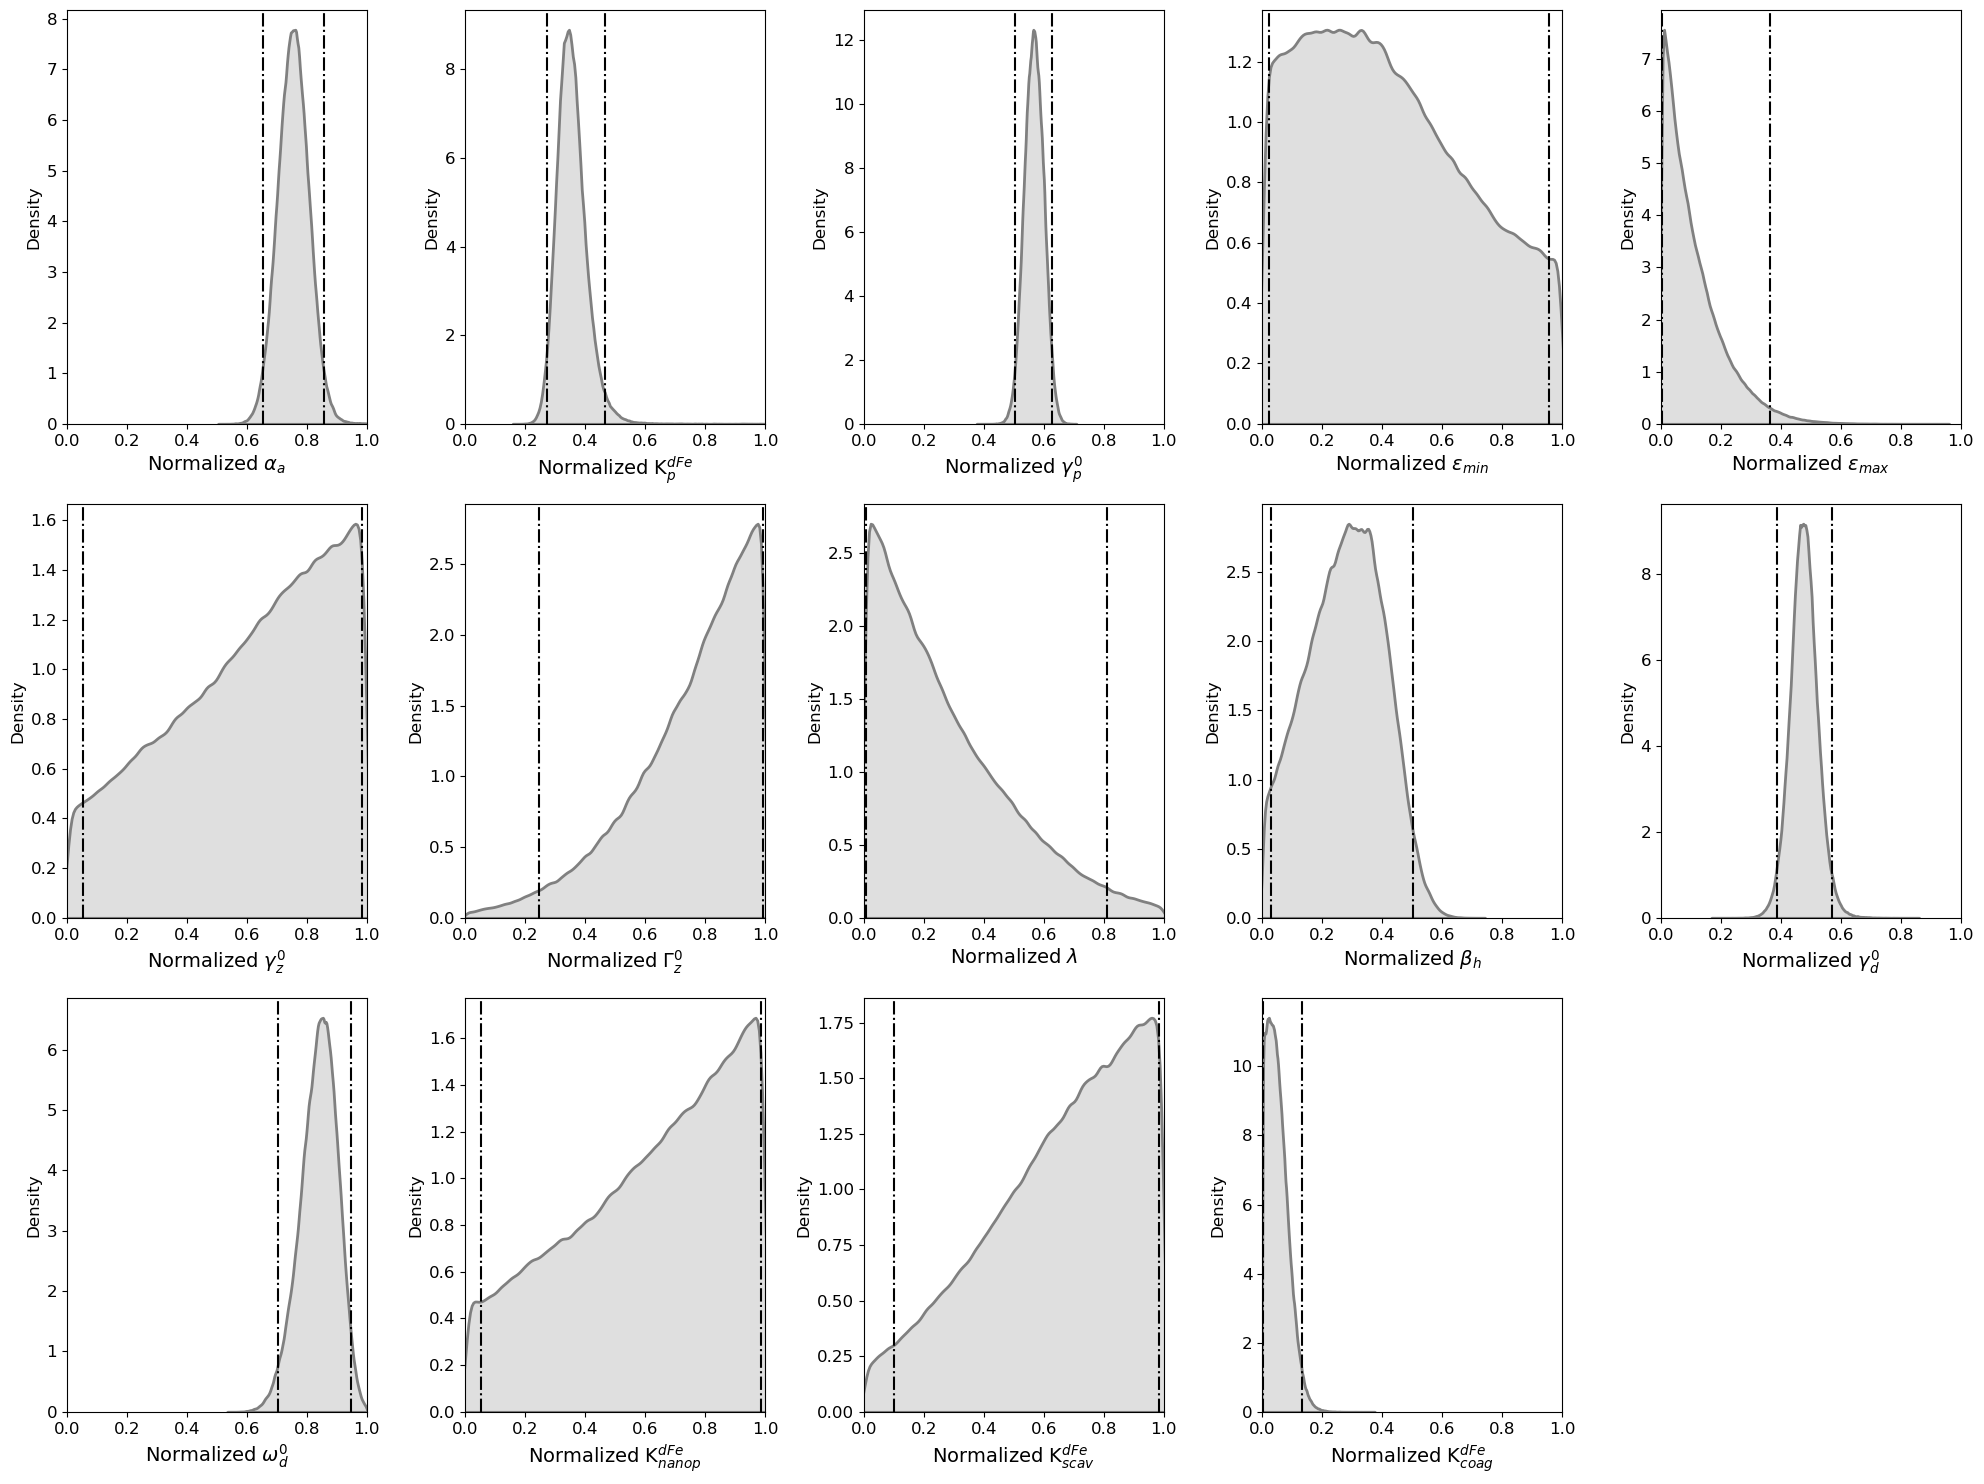

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 15))  # Create a 4x3 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

opt_params = [r'$\alpha_{a}$', r'K$^{dFe}_{p}$', r'$\gamma^{0}_{p}$', 
              r'$\epsilon_{min}$', r'$\epsilon_{max}$', r'$\gamma^{0}_{z}$', 
              r'$\Gamma^{0}_{z}$', r'$\lambda$', r'$\beta_{h}$', 
              r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$',
              r'K$^{dFe}_{nanop}$', r'K$^{dFe}_{scav}$', r'K$^{dFe}_{coag}$']

for i in range(14):
    sns.kdeplot(opt_samples[:, i], fill=True, color='gray', linewidth=2, ax=axes[i])
    
    # Adding 2-sigma confidence interval
    lower, upper = np.percentile(opt_samples[:, i], [2.5, 97.5])
    print(f'{opt_params[i]} - ','p2.5: ', lower, 'p97.5: ', upper)
    axes[i].axvline(x=lower, color='black', linestyle='-.')
    axes[i].axvline(x=upper, color='black', linestyle='-.')
    
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel(f"Normalized {opt_params[i]}", fontsize=14)

# Hide the empty subplot (last one in a 4x3 grid, total 12 subplots)
axes[-1].axis('off')
#axes[-2].axis('off')

plt.tight_layout()
fig.savefig('optimisation_posteriordistributions.png', dpi=300, bbox_inches='tight')


### read in the real values of the parameter sets and tell me the optimal values

In [71]:
param_ranges = pd.read_excel('experiments.xlsx', usecols=(0,1,2))
param_ranges

,WOMBAT-lite,min,max
0,abioa,0.250,1.250
1,phykf,0.100,3.000
2,phylmor,-3.000,-1.000
3,zooepsmin,-3.000,-1.500
4,zooepsmax,-1.500,0.000
5,zoolmor,-3.000,-1.000
6,zooqmor,0.100,1.000
7,zooassi,0.200,0.800
8,bbioh,1.041,1.104
9,detlrem,0.010,1.000


In [72]:
print("Normalised values")
for i in range(14):
    lower, middle, upper = np.percentile(opt_samples[:, i], [2.5, 50.0, 97.5])
    print(f'{opt_params[i]} - ','p2.5: ', lower, 'p50.0', middle, 'p97.5: ', upper)
    


Normalised values
$\alpha_{a}$ -  p2.5:  0.6546779822972503 p50.0 0.7547706122657023 p97.5:  0.8573725873799874
K$^{dFe}_{p}$ -  p2.5:  0.27101986758012014 p50.0 0.3495373979747408 p97.5:  0.46670165625605814
$\gamma^{0}_{p}$ -  p2.5:  0.5042910661844178 p50.0 0.5665607620677644 p97.5:  0.6280007636700401
$\epsilon_{min}$ -  p2.5:  0.020999358953685557 p50.0 0.39353016600928514 p97.5:  0.955254158390038
$\epsilon_{max}$ -  p2.5:  0.003091509587656284 p50.0 0.08085436564253351 p97.5:  0.36483428026986386
$\gamma^{0}_{z}$ -  p2.5:  0.05562378675192374 p50.0 0.6488081367102836 p97.5:  0.9842065308354735
$\Gamma^{0}_{z}$ -  p2.5:  0.24609419023612933 p50.0 0.796544428206223 p97.5:  0.9913960143639029
$\lambda$ -  p2.5:  0.008768508432725232 p50.0 0.218176070547081 p97.5:  0.8107381669988383
$\beta_{h}$ -  p2.5:  0.02890268082991056 p50.0 0.2783022657506282 p97.5:  0.5017287982466244
$\gamma^{0}_{d}$ -  p2.5:  0.3866706136904117 p50.0 0.47538257271734874 p97.5:  0.5699400748401414
$\omega^{

In [74]:
print("Real values")
for i in range(14):
    lower, middle, upper = np.percentile(opt_samples[:, i], [2.5, 50.0, 97.5])
    lower = param_ranges.iloc[i]['min'] + lower * (param_ranges.iloc[i]['max'] - param_ranges.iloc[i]['min'])
    middle = param_ranges.iloc[i]['min'] + middle * (param_ranges.iloc[i]['max'] - param_ranges.iloc[i]['min'])
    upper = param_ranges.iloc[i]['min'] + upper * (param_ranges.iloc[i]['max'] - param_ranges.iloc[i]['min'])
    if i in [2,3,4,5,11,12,13]:
        print(f'{opt_params[i]} - ','p2.5: ', 10**lower, 'p50.0', 10**middle, 'p97.5: ', 10**upper)
    else:
        print(f'{opt_params[i]} - ','p2.5: ', lower, 'p50.0', middle, 'p97.5: ', upper)
    

Real values
$\alpha_{a}$ -  p2.5:  0.9046779822972503 p50.0 1.0047706122657023 p97.5:  1.1073725873799876
K$^{dFe}_{p}$ -  p2.5:  0.8859576159823483 p50.0 1.1136584541267485 p97.5:  1.4534348031425686
$\gamma^{0}_{p}$ -  p2.5:  0.01019957632897563 p50.0 0.013586935825801835 p97.5:  0.01803024081778503
$\epsilon_{min}$ -  p2.5:  0.00107522421974095 p50.0 0.003893097218052159 p97.5:  0.027094506026782764
$\epsilon_{max}$ -  p2.5:  0.031962244131969436 p50.0 0.041810132942238155 p97.5:  0.11149398042632552
$\gamma^{0}_{z}$ -  p2.5:  0.0012919555547000162 p50.0 0.019843408521998833 p97.5:  0.0929850355980401
$\Gamma^{0}_{z}$ -  p2.5:  0.3214847712125164 p50.0 0.8168899853856006 p97.5:  0.9922564129275127
$\lambda$ -  p2.5:  0.20526110505963516 p50.0 0.3309056423282486 p97.5:  0.6864429001993031
$\beta_{h}$ -  p2.5:  1.0428208688922842 p50.0 1.0585330427422897 p97.5:  1.0726089142895374
$\gamma^{0}_{d}$ -  p2.5:  0.39280390755350764 p50.0 0.48062874699017527 p97.5:  0.57424067409174
$\omega

### draw 20 random samples from the posteriors

In [76]:
# Draw parameter sets from the posterior distribution
np.random.seed(99)
n_samples = 20  # or however many you can afford to run
# Randomly draw 10 sets of 11 parameter samples
random_samples = opt_samples[np.random.choice(opt_samples.shape[0], n_samples, replace=False)]

In [80]:
all_params = ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10', 'P11', 'P12','P13','P14']

print('Variables: ', var_names)
# Find the indices of the sensitive parameters in the all_params list
sens_indices = [all_params.index(param) for param in sens_params]
# Create a sample with all parameters set to 0.5
sample = np.full(len(all_params), 0.5)
# Fill the sensitive parameters with the optimised values
for i in range(np.shape(random_samples)[0]):
    #sample[sens_indices] = random_samples[i, :]
    sample = random_samples[i, :]
    #real_sample = [param_ranges.iloc[i]['min'] + value * (param_ranges.iloc[i]['max'] - param_ranges.iloc[i]['min']) for value in sample]
    # Format the sample values to 2 decimal places
    formatted_sample = [f"{value:.3f}" for value in sample]
    print(f'Optimal sample set - {i}: [{", ".join(formatted_sample)}]')

    nrmse_list = []
    for var_name in var_names:
        gpr_model = joblib.load(f'GPR_{var_name}.joblib')
        NRMSE = gpr_model.predict([sample])
        nrmse_list.append(NRMSE[0])
        
    # Format the NRMSE values to 2 decimal places
    formatted_nrmse = [f"{value:.3f}" for value in nrmse_list]
    print(f'N-Error of set - {i}: ', formatted_nrmse)

Variables:  ['surno3', 'surfer', 'surchl', 'chmaxz', 'intnpp', 'fgco2_', 'phylim', 'pocsin']
Optimal sample set - 0: [0.758, 0.362, 0.564, 0.648, 0.034, 0.527, 0.564, 0.088, 0.172, 0.504, 0.736, 0.911, 0.944, 0.016]
N-Error of set - 0:  ['-0.012', '0.114', '0.007', '0.022', '0.005', '0.011', '0.001', '0.100']
Optimal sample set - 1: [0.770, 0.412, 0.563, 0.212, 0.170, 0.408, 0.976, 0.155, 0.482, 0.459, 0.943, 0.541, 0.735, 0.003]
N-Error of set - 1:  ['0.008', '0.085', '0.009', '0.021', '0.005', '0.055', '-0.026', '0.094']
Optimal sample set - 2: [0.779, 0.351, 0.592, 0.178, 0.092, 0.417, 0.422, 0.015, 0.405, 0.481, 0.956, 0.591, 0.526, 0.055]
N-Error of set - 2:  ['0.014', '0.092', '0.004', '0.029', '0.000', '0.035', '-0.002', '0.100']
Optimal sample set - 3: [0.716, 0.313, 0.549, 0.178, 0.072, 0.052, 0.916, 0.184, 0.200, 0.539, 0.867, 0.223, 0.483, 0.026]
N-Error of set - 3:  ['0.003', '0.126', '0.010', '0.007', '0.008', '-0.009', '-0.005', '0.114']
Optimal sample set - 4: [0.773, 0.